In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from warnings import filterwarnings
filterwarnings("ignore" , category = DeprecationWarning)
filterwarnings("ignore", category= FutureWarning)

In [3]:
from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error,mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.metrics import roc_curve,roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier , VotingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
pd.set_option("display.float_format", lambda x : "%.5f" % x)
pd.set_option("display.max_columns" , None)
pd.set_option("display.width" , 200)

In [5]:
path = "/Users/gokhanersoz/Desktop/Project/"

In [6]:
train_ = pd.read_csv(path+"train.csv",index_col = 0)
test_ = pd.read_csv(path+"test.csv",index_col = 0)

In [7]:
train = train_.copy()
test = test_.copy()

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
#reduced_train = reduce_mem_usage(train)
#reduced_test = reduce_mem_usage(test)

In [10]:
#del train
#del test

In [11]:
# Bütün Değerler Dolu
train.isnull().sum().sum()

0

In [12]:
# Bütün Değerler Dolu
test.isnull().sum().sum()

0

In [13]:
######################################################
# Modeling
######################################################

In [14]:
X = train.drop(["isFraud","TransactionID"] , axis = 1)
y = train["isFraud"]

In [15]:
print("X Shape : {}".format(X.shape))
print("Y Shape : {}".format(y.shape))

X Shape : (590015, 370)
Y Shape : (590015,)


In [16]:
cat_cols = ['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'day_risk',
 'hours_risk',
 'Risk_Transaction',
 'Risk_ProductCD',
 'OS_id_30',
 'Version_id_30',
 'Browser_id_31',
 'Version_id_31',
 'Width_id_33',
 'Height_id_33',
 'DeviceCorp']
len(cat_cols)

40

In [17]:
num_cols = [col for col in X.columns if X[col].dtype != "object"]

for col in cat_cols:
    num_cols.remove(col)
len(num_cols)

330

In [18]:
X_Others = X[cat_cols]
X_Numbers = X[num_cols]

In [21]:
X_Test = test.drop("TransactionID", axis = 1)
X_Test_Others = X_Test[cat_cols]
X_Test_Numbers = X_Test[num_cols]

In [22]:
print("X_Test_Others Shape : {}".format(X_Test_Others.shape))
print("X_Test_Numbers Shape : {}".format(X_Test_Numbers.shape))

X_Test_Others Shape : (506691, 40)
X_Test_Numbers Shape : (506691, 330)


In [23]:
print("X_Others Shape : {}".format(X_Others.shape))
print("X_Numbers Shape : {}".format(X_Numbers.shape))

X_Others Shape : (590015, 40)
X_Numbers Shape : (590015, 330)


In [24]:
std = StandardScaler()
X_Scaled = std.fit_transform(X_Numbers)
X_Scaled = pd.DataFrame(data = X_Scaled , columns = X_Numbers.columns)
X_Scaled.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32,day,hours,LogTransactionAmt,Trans_min_mean,Trans_min_std,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4
0,-1.57963,-0.28665,0.82179,-0.00959,-0.28016,-1.39715,0.24327,0.06985,-0.13931,-0.13942,-0.12373,-0.05928,-0.21616,-0.13882,-0.04323,-0.05797,-0.20886,-0.05642,-0.10934,-0.04596,-0.27189,-0.17715,-0.50895,-0.28543,-0.13223,-0.48041,-0.24226,-0.15528,-0.15237,0.11311,-0.55649,-0.58514,-0.13263,-0.08295,-0.12738,-0.76922,0.00537,-0.13559,-0.17429,0.24645,0.18485,-0.13743,-0.17135,-0.10757,-0.13221,-0.55120,-0.54095,0.76949,0.67907,-0.34071,-0.33349,-0.34048,-0.33714,0.39825,0.30711,-0.35384,-0.34075,-0.68437,-0.66225,-0.36577,-0.35769,-0.35465,-0.35993,0.67584,0.60772,-0.13164,-0.15873,-0.30347,-0.28970,0.02285,-0.33544,-0.32133,-0.11051,-0.13915,-0.11258,-0.13963,-0.59116,-0.57686,-0.36095,-0.34676,-0.34198,0.73693,0.64104,-0.17018,-0.33844,-0.32720,-0.32664,-0.31427,0.36023,0.25423,-0.33900,-0.32191,-0.68345,-0.66335,-0.35526,-0.34332,-0.35100,-0.35617,0.77109,0.67581,-0.16979,-0.32739,-0.31946,-0.30730,-2.20635,-2.06372,-0.34435,-0.32481,-0.17859,-0.68709,-0.66251,-0.36304,-0.34937,-0.36145,-0.04934,-0.04984,-0.06205,-0.32875,-0.28870,-0.05537,-0.05181,-0.06779,-0.29174,-0.19317,-0.03159,-0.02063,-0.03171,-0.06445,-0.05709,-0.05607,-0.12524,-0.12198,-0.08349,-0.08196,0.14103,0.12651,-0.11871,-0.12677,-0.13705,0.15863,0.15285,0.13541,0.12206,0.09674,0.08270,-0.11611,-0.11890,-0.03054,-0.03538,-0.03242,-0.05360,-0.09842,-0.10398,-0.04513,-0.05249,-0.08891,-0.11832,-0.13322,-0.06866,-0.09970,-0.15684,-0.11770,-0.09855,-0.04143,-0.04640,-0.04673,-0.07294,-0.09710,-0.07129,-0.07916,-0.11580,-0.11812,-0.05877,-0.04139,-0.01071,-0.02346,-0.06942,-0.04220,-0.04365,-0.04236,0.08552,0.05875,-0.03711,0.07227,0.03736,-0.07789,-0.04634,-0.05421,-0.04596,-0.05730,-0.05497,-0.03287,-0.01568,-0.03788,-0.07244,-0.06738,-0.07998,-0.04113,-0.04951,-0.04750,-0.03264,-0.06189,-0.05063,-0.05157,-0.05783,-0.05298,-0.08156,-0.04897,-0.05966,-0.10633,-0.05351,-0.06898,-0.04210,-0.03511,-0.11447,-0.06888,-0.10103,-0.04035,-0.04494,-0.04185,-0.08932,-0.09431,-0.06664,-0.06880,-0.10694,-0.10675,-0.00935,-0.00481,-0.07977,-0.05945,-0.07877,0.03300,-0.08195,-0.04211,-0.03662,-0.03789,0.19790,0.18898,-0.03852,-0.02107,-0.02594,0.09892,0.09191,-0.08933,-0.07907,0.00741,0.04373,-0.03802,-0.01009,-0.04245,-0.04134,-0.04476,-0.02065,-0.02657,-0.02832,-0.01360,-0.05714,-0.06179,-0.05891,-0.03699,-0.03987,-0.0

In [25]:
X_Test_Numbers_Scaled = std.transform(X_Test_Numbers)
X_Test_Numbers_Scaled = pd.DataFrame(data = X_Test_Numbers_Scaled, columns = X_Test_Numbers.columns)
X_Test_Numbers_Scaled.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32,day,hours,LogTransactionAmt,Trans_min_mean,Trans_min_std,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4
0,2.38874,-0.44421,0.10419,-1.60609,-0.28016,0.64426,-1.26728,0.06985,-0.21418,-0.06819,-0.06496,-0.05928,-0.09987,-0.07476,-0.04323,-0.05797,0.09087,-0.05642,-0.05479,-0.02102,0.77939,-0.03633,2.06114,2.12709,0.16220,1.71397,0.02567,-0.15528,-0.15437,0.11311,1.76611,0.72802,-0.13263,-0.08295,-0.12738,1.37129,0.00537,-0.13559,-0.17429,0.24645,0.18485,-0.13743,-0.17135,-0.10757,-0.13221,1.70115,1.59997,-1.23488,-1.26389,-0.34071,-0.33349,-0.34048,-0.33714,-2.08902,-2.00757,-0.35384,-0.34075,-0.68437,-0.66225,-0.36577,-0.35769,-0.35465,-0.35993,0.67584,0.60772,-0.13164,-0.15873,-0.30347,-0.28970,0.02285,-0.33544,-0.32133,-0.11051,-0.13915,-0.11258,-0.13963,1.56815,1.45313,-0.36095,-0.34676,-0.34198,-1.27248,-1.30242,-0.17018,-0.33844,-0.32720,-0.32664,-0.31427,-2.07148,-1.95122,-0.33900,-0.32191,-0.68345,-0.66335,-0.35526,-0.34332,-0.35100,-0.35617,-1.22453,-1.25720,-0.16979,-0.32739,-0.31946,-0.30730,0.33572,0.23012,-0.34435,-0.32481,-0.17859,1.32500,1.19178,-0.36304,-0.34937,-0.36145,-0.04934,-0.04984,-0.06205,0.03850,-0.28870,-0.05537,-0.06810,-0.06779,-0.14000,-0.19317,-0.03159,-0.02063,-0.03171,-0.06445,-0.05709,-0.05607,-0.12524,-0.12198,-0.08349,-0.08196,0.14103,0.12651,-0.11871,-0.12677,-0.13705,0.15863,0.15285,0.13541,0.12206,0.09674,0.08270,-0.11611,-0.11890,-0.03054,-0.03538,-0.03242,-0.05360,-0.09842,-0.10398,-0.04513,-0.05249,-0.08891,-0.11832,-0.13322,-0.06866,-0.09970,-0.15684,-0.11770,-0.09855,-0.04143,-0.04640,-0.04673,-0.07294,-0.09710,-0.07129,-0.07916,-0.11580,-0.11812,-0.05877,-0.04139,-0.01071,-0.02346,-0.06942,-0.04220,-0.04365,-0.04236,0.08552,0.05875,-0.03711,0.07227,0.03736,-0.07789,-0.04634,-0.05421,-0.04596,-0.05730,-0.05497,-0.03287,-0.01568,-0.03788,-0.07244,-0.06738,-0.07998,-0.04113,-0.04951,-0.04750,-0.03264,-0.06189,-0.05063,-0.05157,-0.05783,-0.05298,-0.08156,-0.04897,-0.05966,-0.10633,-0.05351,-0.06898,-0.04210,-0.03511,-0.11447,-0.06888,-0.10103,-0.04035,-0.04494,-0.04185,-0.08932,-0.09431,-0.06664,-0.06880,-0.10694,-0.10675,-0.00935,-0.00481,-0.07977,-0.05945,-0.07877,0.03300,-0.08195,-0.04211,-0.03662,-0.03789,0.19790,0.18898,-0.03852,-0.02107,-0.02594,0.09892,0.09191,-0.08933,-0.07907,0.00741,0.04373,-0.03802,-0.01009,-0.04245,-0.04134,-0.04476,-0.02065,-0.02657,-0.02832,-0.01360,-0.05714,-0.06179,-0.05891,-0.03699,-0.03987,-0.03881,-0.02

In [26]:
print("X_Test_Others Shape : {}".format(X_Test_Others.shape))
print("X_Test_Numbers_Scaled Shape : {}".format(X_Test_Numbers.shape))

X_Test_Others Shape : (506691, 40)
X_Test_Numbers_Scaled Shape : (506691, 330)


In [27]:
print("X_Others Shape : {}".format(X_Others.shape))
print("X_Numbers_Scaled Shape : {}".format(X_Scaled.shape))

X_Others Shape : (590015, 40)
X_Numbers_Scaled Shape : (590015, 330)


In [28]:
from sklearn.decomposition import PCA

pca = PCA()
pca_fit = pca.fit_transform(X_Scaled)

In [29]:
np.cumsum(pca.explained_variance_ratio_)[:50]

array([0.13828882, 0.24915907, 0.30841696, 0.35039957, 0.38798081,
       0.42079147, 0.45028326, 0.4773936 , 0.50228722, 0.52483452,
       0.54608666, 0.56643348, 0.5842248 , 0.60129405, 0.61783886,
       0.63381878, 0.6485314 , 0.66225365, 0.67471232, 0.68700342,
       0.6964654 , 0.70589431, 0.7143548 , 0.721878  , 0.72900366,
       0.73600971, 0.74278545, 0.74930124, 0.75527938, 0.76116209,
       0.76682408, 0.77219312, 0.77735132, 0.78225345, 0.78705263,
       0.79161503, 0.79597599, 0.80017751, 0.80418243, 0.80806334,
       0.81192897, 0.81578179, 0.8193498 , 0.82273417, 0.82601394,
       0.8292618 , 0.83245592, 0.83558641, 0.83868694, 0.84173871])

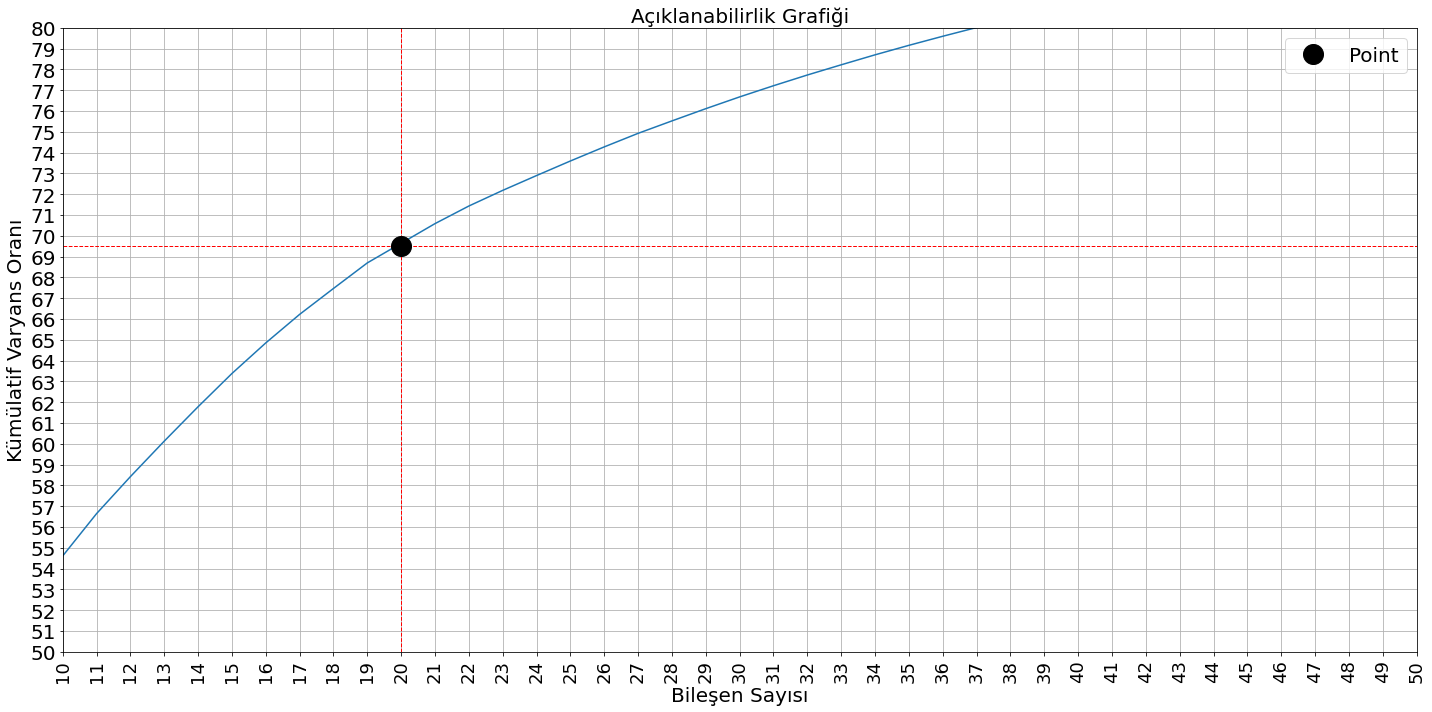

In [30]:
plt.figure(figsize = (20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)

plt.xlabel("Bileşen Sayısı", size = 20)
plt.ylabel("Kümülatif Varyans Oranı", size = 20)
plt.title("Açıklanabilirlik Grafiği" , size = 20)

plt.xticks(range(1,331),rotation=90,fontsize = 18)
plt.yticks(range(1,101),fontsize = 20)

plt.xlim([10,50])
plt.ylim([50,80])

plt.axvline(x = 20, color = "r", ls = "--", lw = 1)
plt.axhline(y = 69.5, color = "r", ls = "--", lw = 1)
plt.plot(20,69.5,"o",label = "Point",markersize = 20,color = "black")
plt.legend(fontsize = 20)

plt.grid()
plt.tight_layout()
plt.show()

In [31]:
# Final Model For PCA

N = 20

pca = PCA(n_components= N)
pca_fit = pca.fit_transform(X_Scaled)
print(pca_fit.shape)

(590015, 20)


In [32]:
columns= ["PCA" + str(i) for i in range(1,N+1)]

final_pca = pd.DataFrame(data = pca_fit , columns = columns)
final_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20
0,-1.29335,-1.80199,0.10996,-0.42423,0.13479,1.32056,0.90301,0.94419,-1.79183,-0.31604,-0.19989,-1.52241,-0.06007,0.32352,-0.30553,0.53726,0.70706,1.49995,0.17391,-0.35934
1,-0.95301,-0.40988,-0.29555,-0.13629,-0.35873,0.38981,0.35269,0.41994,-1.28658,-0.19639,0.77103,-1.42341,0.26971,0.44007,0.60405,-0.41777,-1.93236,0.75004,-0.70829,-1.62916
2,-1.33818,-1.77392,0.13154,-0.33431,0.11720,1.28422,0.81353,0.85853,-1.60548,-0.29694,-0.32121,-1.14510,0.05808,-0.02186,0.54741,0.20021,-0.58801,1.16451,-0.49737,-0.20935
3,0.49842,-2.64123,-0.17417,-0.24622,-0.33819,0.92145,0.71336,1.65817,-0.42488,-0.25952,-1.56075,-2.68892,1.16771,0.71451,1.55537,-0.03743,-0.23749,-2.57360,-1.00549,0.28413
4,1.07153,-2.19715,-3.12087,-13.31345,8.50991,10.14181,-2.62562,-3.92357,1.64525,-2.41268,3.14221,2.37288,1.62133,-1.23552,-0.64324,-2.90633,0.68612,-0.82745,0.25241,-0.97594


In [33]:
final_test_pca = pca.transform(X_Test_Numbers_Scaled)
final_test_pca = pd.DataFrame(data = final_test_pca, columns = columns)
final_test_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20
0,-1.32569,-1.97941,-0.17935,0.83146,-1.05781,-2.49751,-1.89793,-1.70965,0.82894,0.31793,2.60475,-2.17331,0.61062,0.71532,-1.01410,0.06146,-0.93893,-1.03184,1.23538,-0.38199
1,-0.93523,-1.97118,-0.05223,0.03978,-0.46792,-0.21527,-0.10476,0.49967,-0.28875,-0.00873,0.25353,-2.53372,1.25016,0.90245,1.01961,-0.25000,-2.48668,-1.86641,-0.50659,-0.00432
2,-0.85123,-1.98417,0.14953,-0.00386,-0.26177,0.78694,0.74288,1.33034,-0.50526,0.15420,-1.54074,-0.45645,0.84262,1.05253,0.98837,-0.24778,-1.54116,-0.61320,-0.26802,0.01264
3,-1.50908,-2.63450,1.07912,1.42797,-0.83309,-0.08924,-0.88999,-1.42456,2.25671,1.65164,-2.82554,3.14781,-0.46309,-1.61972,0.49514,1.51141,2.36899,-0.06093,-1.04324,1.05663
4,-1.16117,-2.70964,0.29671,0.74194,-0.73204,-0.88510,-0.51091,-0.50417,1.21782,0.17906,-0.65908,1.08264,-0.47145,-2.63105,1.59172,0.32668,3.02146,-0.12969,-1.45195,0.48748


In [34]:
final_test_pca.shape,final_pca.shape

((506691, 20), (590015, 20))

In [35]:
X_Others.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day_risk,hours_risk,Risk_Transaction,Risk_ProductCD,OS_id_30,Version_id_30,Browser_id_31,Version_id_31,Width_id_33,Height_id_33,DeviceCorp
0,4,1,1,4,4,1,1,1,2,0,1,2,2,2,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12
1,4,2,1,1,1,2,2,2,0,1,1,2,2,2,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,0,0,8,0,38,45,155,138,12
2,4,4,2,2,2,1,1,1,0,0,0,0,0,0,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12
3,4,2,2,5,5,2,2,2,0,1,0,2,2,2,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12
4,1,2,1,1,1,2,2,2,3,2,2,2,2,2,1,1,1,1,1,7,123,164,3,1,0,1,1,1,953,0,1,1,1,0,59,35,31,86,12,9


In [36]:
print("X_Others Shape : {}".format(X_Others.shape))
print("Final_PCA Shape : {}".format(final_pca.shape))

X_Others Shape : (590015, 40)
Final_PCA Shape : (590015, 20)


In [37]:
print("X_Test_Others Shape : {}".format(X_Test_Others.shape))
print("Final_Test_PCA Shape : {}".format(final_test_pca.shape))

X_Test_Others Shape : (506691, 40)
Final_Test_PCA Shape : (506691, 20)


In [38]:
X_Others = X_Others.reset_index(drop=True)

In [39]:
# Her iki tarafında indexleri eşit yani !!!

(X_Others.index.values == final_pca.index.values).sum()

590015

In [40]:
final_X = pd.concat([final_pca ,X_Others], axis = 1 )
final_X

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_15,id_16,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day_risk,hours_risk,Risk_Transaction,Risk_ProductCD,OS_id_30,Version_id_30,Browser_id_31,Version_id_31,Width_id_33,Height_id_33,DeviceCorp
0,-1.29335,-1.80199,0.10996,-0.42423,0.13479,1.32056,0.90301,0.94419,-1.79183,-0.31604,-0.19989,-1.52241,-0.06007,0.32352,-0.30553,0.53726,0.70706,1.49995,0.17391,-0.35934,4,1,1,4,4,1,1,1,2,0,1,2,2,2,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12
1,-0.95301,-0.40988,-0.29555,-0.13629,-0.35873,0.38981,0.35269,0.41994,-1.28658,-0.19639,0.77103,-1.42341,0.26971,0.44007,0.60405,-0.41777,-1.93236,0.75004,-0.70829,-1.62916,4,2,1,1,1,2,2,2,0,1,1,2,2,2,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,0,0,8,0,38,45,155,138,12
2,-1.33818,-1.77392,0.13154,-0.33431,0.11720,1.28422,0.81353,0.85853,-1.60548,-0.29694,-0.32121,-1.14510,0.05808,-0.02186,0.54741,0.20021,-0.58801,1.16451,-0.49737,-0.20935,4,4,2,2,2,1,1,1,0,0,0,0,0,0,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12
3,0.49842,-2.64123,-0.17417,-0.24622,-0.33819,0.92145,0.71336,1.65817,-0.42488,-0.25952,-1.56075,-2.68892,1.16771,0.71451,1.55537,-0.03743,-0.23749,-2.57360,-1.00549,0.28413,4,2,2,5,5,2,2,2,0,1,0,2,2,2,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12
4,1.07153,-2.19715,-3.12087,-13.31345,8.50991,10.14181,-2.62562,-3.92357,1.64525,-2.41268,3.14221,2.37288,1.62133,-1.23552,-0.64324,-2.90633,0.68612,-0.82745,0.25241,-0.97594,1,2,1,1,1,2,2,2,3,2,2,2,2,2,1,1,1,1,1,7,123,164,3,1,0,1,1,1,953,0,1,1,1,0,59,35,31,86,12,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590010,-1.63884,-3.44773,0.43566,0.23824,-0.38912,-0.07281,0.00841,-0.07315,-0.34929,0.19194,0.13083,-1.87850,-0.53152,-0.00858,-2.56937,1.97757,6.38965,0.88715,0.89104,0.17357,4,4,2,4,4,1,1,1,0,1,0,0,0,1,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12
590011,-1.31122,-1.71863,0.12231,-0.34473,0.09397,1.43290,0.99234,1.01545,-1.84557,-0.28883,-0.54411,-1.23167,-0.03098,-0.30575,0.78622,0.39640,-0.09440,1.58118,-0.47772,-0.22971,4,2,2,1,1,1,0,0,0,0,1,0,0,0,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12
590012,-1.72223,-2.59146,0.24811,0.63659,-0.60182,-0.76466,-0.82674,-1.14417,0.33550,0.23009,0.74683,0.81680,-0.72916,-2.68902,1.04085,0.27666,1.79426,1.96474,-0.80539,0.76493,4,2,2,1,1,1,0,0,3,2,1,2,2,2,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12
590013,-0.12244,-0.54924,0.09133,-0.07906,-0.07593,2.38324,2.48837,2.90408,-0.15693,-0.25223,-4.91788,2.40511,0.06128,-2.30054,5.89571,-0.60830,-0.82867,-1.84125,-4.07597,-0.95612,4,2,2,7,7,1,1,1,0,0,1,2,2,2,2,3,2,2,2,75,129,260,4,2,2,2,2,2,1555,0,1,1,0,8,0,38,45,155,138,12


In [41]:
final_test_X = pd.concat([final_test_pca, X_Test_Others], axis = 1)
final_test_X.shape

(506691, 60)

In [42]:
print("Final X Shape : {}".format(final_X.shape))
print("Final Test X Shape : {}".format(final_test_X.shape))

Final X Shape : (590015, 60)
Final Test X Shape : (506691, 60)


In [43]:
#cross_validate(LGBMClassifier(), X_Scaled , y , cv = 5, n_jobs= -1 ,verbose = 0,scoring = ["roc_auc"])

#{'fit_time': array([48.59815192, 48.32667398, 48.74104285, 49.81634212, 48.65108585]),
# 'score_time': array([1.56899905, 2.21890092, 2.01403904, 1.77422285, 1.84209418]),
# 'test_roc_auc': array([0.87814876, 0.69500361, 0.77256003, 0.83135651, 0.89563924])}

In [44]:
#cross_validate(LGBMClassifier(), X , y , cv = 5, n_jobs= -1 ,verbose = 0,scoring = ["roc_auc"])

#{'fit_time': array([44.84907818, 45.47281504, 45.22068   , 44.94039392, 45.02587438]),
# 'score_time': array([2.25247407, 2.45605206, 2.65004396, 2.78175521, 2.59498978]),
# 'test_roc_auc': array([0.85947535, 0.75429262, 0.76046782, 0.87373185, 0.89652319])}

In [45]:
# 50 ide öncesinde
#cross_validate(DecisionTreeClassifier(), 
#               final_X , 
#               y , 
#               cv = 2, 
#               n_jobs= -1 ,
#               verbose = 0,
#               scoring = ["roc_auc","accuracy"])

In [46]:
# LR, AdaBoost,Navie_Bayes , LightGBM, CART Bunları kullan hızlı olması için !!!!

classifiers = [ ("LR", LogisticRegression()),
                #("KNN", KNeighborsClassifier()),
                ("CART" , DecisionTreeClassifier()),
                #("RF", RandomForestClassifier()),
                #("SVC" , SVC()),
                #("Adaboost" , AdaBoostClassifier()),
                 ("Gaussion",GaussianNB()),
                #("GBM" , GradientBoostingClassifier()),
                #("XGBoost", XGBClassifier()),
                 ("LightGBM", LGBMClassifier()),
                #("CatBoost" , CatBoostClassifier())
               ]

In [47]:
def base_model_advanced(X , y ,classifiers, cv = 3):
    

    data = pd.DataFrame()
    index = 0
    
    for name,classifier in classifiers:
        
        cv_results = cross_validate(estimator= classifier,
                                    X = X ,
                                    y = y,
                                    n_jobs= -1,
                                    verbose=0,
                                    cv = cv,
                                    scoring = ["roc_auc","accuracy"])
        
        data.loc[index,"Classifiers_Name"] = name
        data.loc[index,"Roc_Auc_Score"] = cv_results["test_roc_auc"].mean()
        data.loc[index,"Accuracy_Score"] = cv_results["test_accuracy"].mean()
        data.loc[index,"Fit Time"] = cv_results["fit_time"].mean()
        data.loc[index,"Score Time"] = cv_results["score_time"].mean()
        index+=1
        
    
    data = data.set_index("Classifiers_Name")
    data = data.sort_values("Roc_Auc_Score" , ascending = False)
    data = data.style.background_gradient(cmap = "summer_r")
    return data
    

In [48]:
base_model_advanced(final_X, y , classifiers, cv = 2)

,Roc_Auc_Score,Accuracy_Score,Fit Time,Score Time
Classifiers_Name,,,,
LightGBM,0.847189,0.968543,4.263659,4.094326
LR,0.778661,0.967216,2.217452,0.246424
Gaussion,0.702959,0.774645,0.642537,0.803794
CART,0.625917,0.934566,18.485207,0.260555


In [49]:
######################################################
# Automated Hyperparameter Optimization
######################################################


#xgboost_params = {
#                   "learning_rate": [0.1, 0.01],
#                  "max_depth": [5, 8, 12, 20],
#                  "n_estimators": [100, 200],
#                  "colsample_bytree": [0.5, 0.8, 1]}

#knn_params = {
#                "weights" : ['uniform', 'distance'],
#                "n_neighbors": range(2, 50)
#             }

#rf_params = {"max_depth": [ 8, 15, None],
#             "max_features": [5, 7, "auto"],
#             "min_samples_split": [8, 15, 20],
#             "n_estimators": [ 500, 1000]
#            }

#gbm_params = {"learning_rate": [0.01, 0.1],
#              "max_depth": [3, 8],
#              "n_estimators": [500, 1000],
#              "subsample": [1, 0.5, 0.7]}


#adaboost_params = {
#                    'n_estimators' : [10, 50, 100, 500]
#                    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0]
#                     "algorithm" : {'SAMME', 'SAMME.R'}
#                 }

#svc_params = {
#                "C" : [],
#                "kernel" : ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
#                "gamma" : ["scale", "auto"],
#                "max_iter" : [10,20,30]
#}

#"criterion" : ["gini","entropy"],
#"splitter" : ["best","random"],
cart_params = {
                'max_depth': np.arange(1,20,5,dtype = int),
                "min_samples_split": np.arange(2,30,5,dtype = int)}



#"C" : [100, 10, 1.0, 0.1, 0.01],
#"penalty" : ['l1', 'l2', 'elasticnet', 'none'],
#"solver" : ['newton-cg', 'lbfgs', 'liblinear'],
lr_params = {
             "C" : [1.0, 0.1, 0.01],
             "max_iter" : np.linspace(100,200,3,dtype = int)
             }


gaussion_params = {
                    'var_smoothing': np.logspace(0,-9, num=20),
                    "priors" : [None]            
                  }

lightgbm_params = {
                    "learning_rate" : [0.1, 0.01],
                    #"max_depth" : [5,8,12],
                    "n_estimators" : [100,200],
                    "colsample_bytree" : [0.5, 1]
                  }

classifiers_params = [ 
                       #("KNN", KNeighborsClassifier() , knn_params),
                       #("RF", RandomForestClassifier(), rf_params),
                       #("GBM" , GradientBoostingClassifier() , gbm_params),
                       #("AdaBoost" , AdaBoostClassifier() , adaboost_params),
                       #("SVC" , SVC() , svc_params),
                       #("XGBoost" , XGBClassifier(), xgboost_params),
                       ("CART", DecisionTreeClassifier() , cart_params),    
                       ("LR" , LogisticRegression() , lr_params),
                       ("LightGBM", LGBMClassifier() , lightgbm_params),
                       ("Gaussion" ,GaussianNB(), gaussion_params),
                      ]


In [50]:
from warnings import filterwarnings
filterwarnings("ignore" , category = UserWarning)

In [51]:
def hyperparameter_optimization(X , y , classifiers , cv = 2):
    
    print("Hyperparameter Optimization.....",end = "\n\n")
    
    best_models = {}
    index = 0
    data = pd.DataFrame()
    
    for name,classifier,params in classifiers:
        
        print(f" {name.upper()} ".center(50,"#"),end = "\n\n")
        
        base_cv_results = cross_validate(estimator= classifier,
                                         X = X ,
                                         y = y,
                                         cv = cv,
                                         n_jobs= -1,
                                         verbose= 0 ,
                                         scoring = ["roc_auc","accuracy"])
        
        base_cv_results_roc_auc = base_cv_results["test_roc_auc"].mean()
        base_cv_results_accuracy = base_cv_results["test_accuracy"].mean()
        
        print(f"Before GridSearchCV {name.upper()} : ")
        print(f"Roc_Auc : {base_cv_results_roc_auc}, Accuracy : {base_cv_results_accuracy}",end = "\n\n")
        
        best_grid = GridSearchCV(estimator=classifier,
                                 param_grid=params,
                                 cv = cv,
                                 n_jobs=-1,
                                 verbose = False).fit(X ,y)
        
        final_model = classifier.set_params(**best_grid.best_params_).fit(X,y)
        
        final_cv_results = cross_validate(estimator= final_model,
                                          X = X,
                                          y = y,
                                          cv = cv,
                                          n_jobs=-1,
                                          verbose = 0,
                                          scoring = ["roc_auc","accuracy"])
        
        final_cv_results_roc_auc = final_cv_results["test_roc_auc"].mean()
        final_cv_results_accuracy = final_cv_results["test_accuracy"].mean()
        final_cv_results_fit_time = final_cv_results["fit_time"].mean()
        
        print(f"After GridSearchCV {name.upper()} : ")
        print(f"Roc_Auc : {final_cv_results_roc_auc}, Accuracy : {final_cv_results_accuracy}")
        print(f"{name.upper()} Best Params : {best_grid.best_params_}" , end = "\n\n")
        
        best_models[name] = final_model
        
        data.loc[index,"Classifier_Name"] = name
        data.loc[index, "Before GridSearchCV Roc_Auc"] = base_cv_results_roc_auc
        data.loc[index, "Before GridSearchCV Accuracy"] = base_cv_results_accuracy
        data.loc[index, "After GridSearchCV Roc_Auc"] = final_cv_results_roc_auc
        data.loc[index, "After GridSearchCV Accuracy"] = final_cv_results_accuracy
        data.loc[index, "Fit Time"] = final_cv_results_fit_time
        index+=1
        
    data = data.set_index("Classifier_Name")
    data = data.sort_values(by = "After GridSearchCV Roc_Auc" , ascending = False)
    #data = data.style.background_gradient(cmap = "summer_r")
    
    return data, best_models
        

In [52]:
data, best_models = hyperparameter_optimization(final_X, y, classifiers_params)
data

Hyperparameter Optimization.....

###################### CART ######################

Before GridSearchCV CART : 
Roc_Auc : 0.6272476411661869, Accuracy : 0.9334339025304108

After GridSearchCV CART : 
Roc_Auc : 0.7806818193008731, Accuracy : 0.9679177669023621
CART Best Params : {'max_depth': 6, 'min_samples_split': 2}

####################### LR #######################

Before GridSearchCV LR : 
Roc_Auc : 0.7786605893284531, Accuracy : 0.9672160888209465

After GridSearchCV LR : 
Roc_Auc : 0.7804200876115863, Accuracy : 0.9672889681028206
LR Best Params : {'C': 0.01, 'max_iter': 150}

#################### LIGHTGBM ####################

Before GridSearchCV LIGHTGBM : 
Roc_Auc : 0.8471885052587609, Accuracy : 0.968543173010296

After GridSearchCV LIGHTGBM : 
Roc_Auc : 0.834380892351797, Accuracy : 0.9691736668055233
LIGHTGBM Best Params : {'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 200}

#################### GAUSSION ####################

Before GridSearchCV GAUSSION

,Before GridSearchCV Roc_Auc,Before GridSearchCV Accuracy,After GridSearchCV Roc_Auc,After GridSearchCV Accuracy,Fit Time
Classifier_Name,,,,,
LightGBM,0.84719,0.96854,0.83438,0.96917,7.29876
CART,0.62725,0.93343,0.78068,0.96792,4.61221
LR,0.77866,0.96722,0.78042,0.96729,3.06706
Gaussion,0.70296,0.77464,0.72483,0.95939,0.42894


In [53]:
best_models

{'CART': DecisionTreeClassifier(max_depth=6),
 'LR': LogisticRegression(C=0.01, max_iter=150),
 'LightGBM': LGBMClassifier(colsample_bytree=1, learning_rate=0.01, n_estimators=200),
 'Gaussion': GaussianNB(var_smoothing=1.0)}

In [54]:
import joblib
joblib.dump(best_models["LightGBM"],"/Users/gokhanersoz/Desktop/Project/pkl/LightGBM.pkl")
joblib.dump(best_models["LR"] , "/Users/gokhanersoz/Desktop/Project/pkl/LR.pkl")
joblib.dump(best_models["Gaussion"], "/Users/gokhanersoz/Desktop/Project/pkl/Gaussion.pkl")
joblib.dump(best_models["CART"], "/Users/gokhanersoz/Desktop/Project/pkl/CART.pkl")

['/Users/gokhanersoz/Desktop/Project/pkl/CART.pkl']

In [55]:
light_gbm = joblib.load("/Users/gokhanersoz/Desktop/Project/pkl/LightGBM.pkl")
cart = joblib.load("/Users/gokhanersoz/Desktop/Project/pkl/CART.pkl")
lr = joblib.load("/Users/gokhanersoz/Desktop/Project/pkl/LR.pkl")
gaussion = joblib.load("/Users/gokhanersoz/Desktop/Project/pkl/Gaussion.pkl")

In [56]:
best_lightgbm_train_predict_proba = light_gbm.predict_proba(final_X)
#best_lightgbm_test_predict = light_gbm.predict_proba(final_test_X)

#y_test_lgbm = light_gbm.predict(final_test_X)
#y_test_lgbm = pd.DataFrame(data = y_test_lgbm , columns = ["isFraud"] )
y_train_lgbm = pd.DataFrame(y)

#####################

best_cart_train_predict_proba = cart.predict_proba(final_X)
#best_cart_test_predict = cart.predict_proba(final_test_X)

#y_test_cart = cart.predict(final_test_X)
#y_test_cart = pd.DataFrame(data = y_test_cart, columns = ["isFraud"] )
y_train_cart = pd.DataFrame(y)

#####################

best_lr_train_predict_proba = lr.predict_proba(final_X)
#best_lr_test_predict = lr.predict_proba(final_test_X)

#y_test_lr = cart.predict(final_test_X)
#y_test_lr = pd.DataFrame(data = y_test_lr, columns = ["isFraud"] )

y_train_lr = pd.DataFrame(y)

#####################

best_gaussion_train_predict_proba = gaussion.predict_proba(final_X)
#best_gaussion_test_predict = cart.predict_proba(final_test_X)

#y_test_gaussion= cart.predict(final_test_X)
#y_test_gaussion = pd.DataFrame(data = y_test_gaussion, columns = ["isFraud"] )

y_train_gaussion = pd.DataFrame(y)

#####################


In [57]:
lgbm_auc = roc_auc_score(y_train_lgbm["isFraud"],best_lightgbm_train_predict_proba[:,1])
cart_auc = roc_auc_score(y_train_cart["isFraud"],best_cart_train_predict_proba[:,1])
lr_auc = roc_auc_score(y_train_lr["isFraud"],best_lr_train_predict_proba[:,1])
gaussion_auc = roc_auc_score(y_train_gaussion["isFraud"],best_gaussion_train_predict_proba[:,1])

print("Best LightGBM Train Auc : {}".format(lgbm_auc))

print("Best Cart Train Auc : {}".format(cart_auc))

print("Best LR Train Auc : {}".format(lr_auc))

print("Best Gaussion Train Auc : {}".format(gaussion_auc))

Best LightGBM Train Auc : 0.8600480893573166
Best Cart Train Auc : 0.8130199618912587
Best LR Train Auc : 0.7907201671494668
Best Gaussion Train Auc : 0.7270731606961385


In [58]:
y_score_lgbm = best_lightgbm_train_predict_proba[:,1]
y_score_cart = best_cart_train_predict_proba[:,1]
y_score_lr = best_lr_train_predict_proba[:,1]
y_score_gaussion = best_gaussion_train_predict_proba[:,1]

fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_train_lgbm, y_score_lgbm)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train_lgbm, y_score_lr)
fpr_cart, tpr_cart, thresholds_cart = roc_curve(y_train_lgbm, y_score_cart)
fpr_gaussion, tpr_gaussion, thresholds_gaussion = roc_curve(y_train_lgbm, y_score_gaussion)

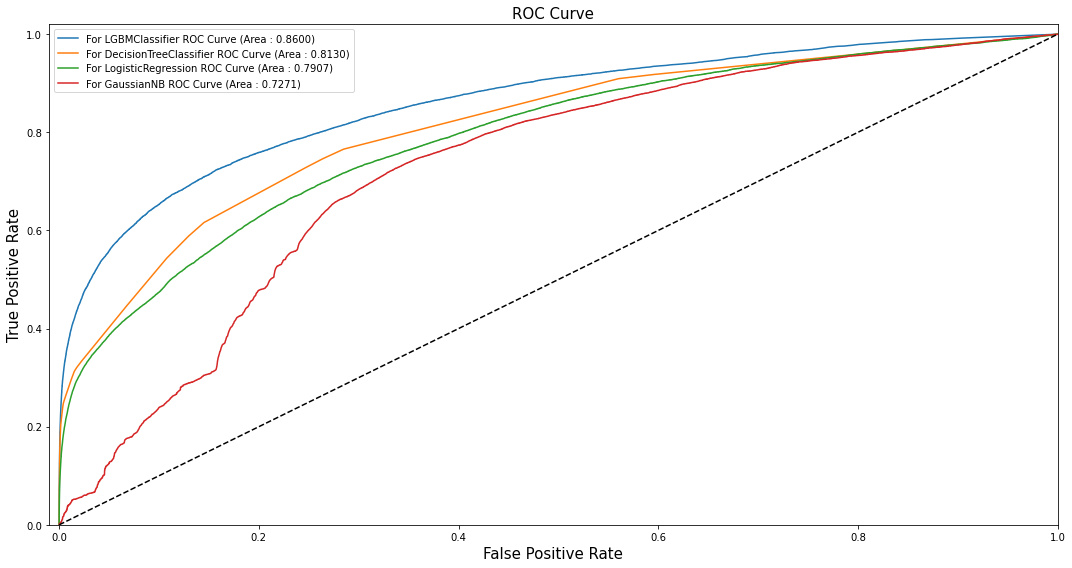

In [59]:
plt.figure(figsize = (15,8))

plt.plot(fpr_lgbm, tpr_lgbm, 
         label = "For LGBMClassifier ROC Curve (Area : %.4f)" % lgbm_auc)
        
plt.plot(fpr_cart, tpr_cart, 
         label = "For DecisionTreeClassifier ROC Curve (Area : %.4f)" % cart_auc)

plt.plot(fpr_lr, tpr_lr, 
         label = "For LogisticRegression ROC Curve (Area : %.4f)" % lr_auc)

plt.plot(fpr_gaussion, tpr_gaussion, 
         label = "For GaussianNB ROC Curve (Area : %.4f)" % gaussion_auc)

plt.plot([0,1],[0,1],"k--",)
plt.xlim([-0.01,1])
plt.ylim([0,1.02])
plt.title("ROC Curve", fontsize = 15)
plt.xlabel("False Positive Rate", fontsize = 15)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

In [60]:
lightgbm_predict = light_gbm.predict(final_X)
cart_predict = cart.predict(final_X)
lr_predict = lr.predict(final_X)
gaussion_predict = gaussion.predict(final_X)

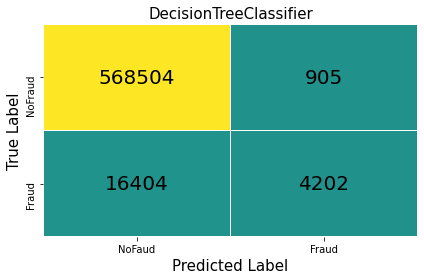

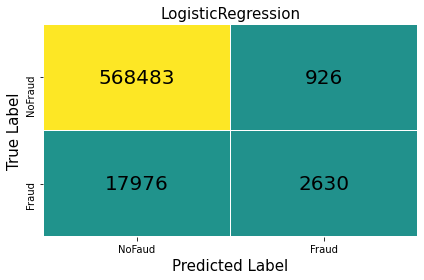

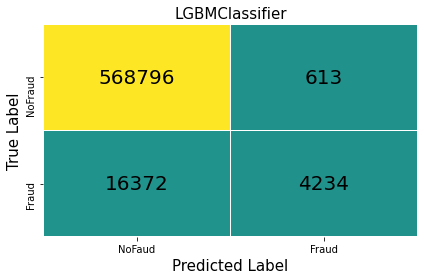

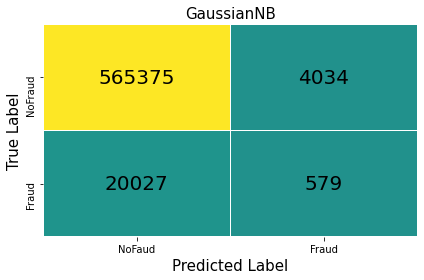

In [62]:
for col in best_models.keys():
    
    name = type(best_models[col]).__name__
    sns.heatmap(confusion_matrix(y , best_models[col].predict(final_X)),
                annot=True,
                annot_kws={"size" : 20, "color" : "black"},
                cmap = "viridis",
                fmt = ".0f",
                cbar = False,
                linewidths=0.5,
                xticklabels=["NoFaud","Fraud"],
                yticklabels=["NoFraud","Fraud"],
                center = 0);
    
    plt.xlabel("Predicted Label" , size = 15)
    plt.ylabel("True Label" , size = 15)
    plt.title(name,size = 15)
    plt.tight_layout()
    plt.show()

## Voting Classifiers 

In [63]:
estimators = []
for col in data.index.tolist():
    estimators.append((col, best_models[col]))
    
estimators

[('LightGBM',
  LGBMClassifier(colsample_bytree=1, learning_rate=0.01, n_estimators=200)),
 ('CART', DecisionTreeClassifier(max_depth=6)),
 ('LR', LogisticRegression(C=0.01, max_iter=150)),
 ('Gaussion', GaussianNB(var_smoothing=1.0))]

In [66]:
def voting_classifier(X , y , cv = 3, estimators = None):
    
    voting_data = pd.DataFrame()
    
    voting_classifier = VotingClassifier(estimators= estimators,
                                 voting="soft")
    voting_classifier.fit(X,y)
    
    cv_results = cross_validate(estimator=voting_classifier,
                                X = X,
                                y = y,
                                cv = cv,
                                scoring = ["roc_auc","accuracy"])
    
    voting_data.loc["Voting_Classifier","Roc_Auc"] = cv_results["test_roc_auc"].mean()
    voting_data.loc["Voting_Classifier","Accuracy"] = cv_results["test_accuracy"].mean()
    voting_data.loc["Voting_Classifier","Fit_Time"] = cv_results["fit_time"].mean()
    voting_data.loc["Voting_Classifier","Score_Time"] = cv_results["score_time"].mean()
    
    return voting_data,voting_classifier

In [67]:
voting_data ,voting_classifier = voting_classifier(final_X, y , cv = 3 ,estimators= estimators)

In [68]:
voting_data

,Roc_Auc,Accuracy,Fit_Time,Score_Time
Voting_Classifier,0.81510,0.96808,13.39400,1.09690


In [69]:
voting_predict = voting_classifier.predict(final_X)
voting_score = voting_classifier.predict_proba(final_X)[:,1]

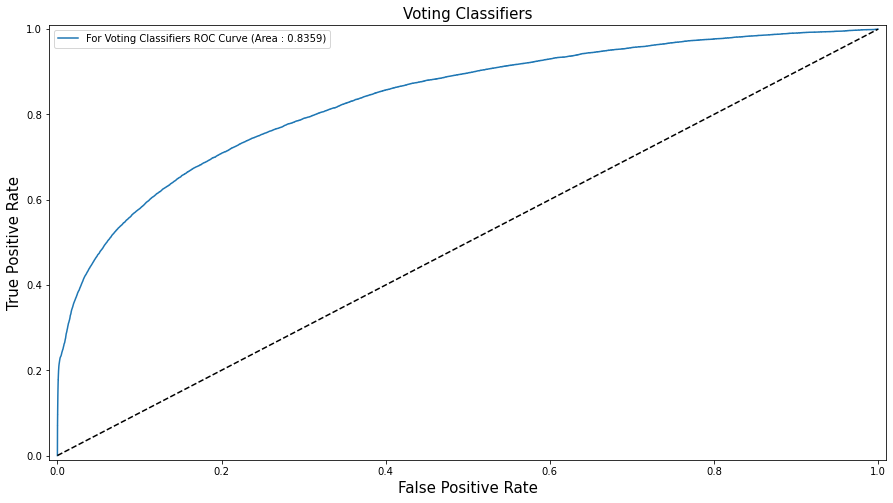

In [70]:
voting_roc_auc_score = roc_auc_score(y, voting_score)

fpr_voting, tpr_voting, threshold_voting = roc_curve(y, voting_score)


plt.figure(figsize = (15,8))
plt.plot(fpr_voting, tpr_voting,
         label = "For Voting Classifiers ROC Curve (Area : %.4f)" %voting_roc_auc_score)

plt.plot([0,1],[0,1],"k--")
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.legend(loc = 0)
plt.title("Voting Classifiers",size = 15)
plt.xlabel("False Positive Rate", size = 15)
plt.ylabel("True Positive Rate", size = 15)
plt.show()

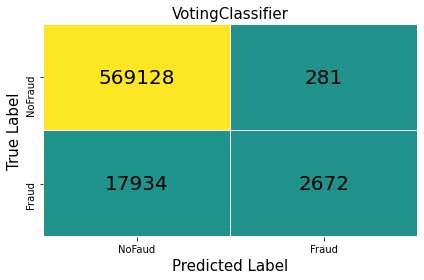

In [72]:
name = type(voting_classifier).__name__
sns.heatmap(confusion_matrix(y , voting_classifier.predict(final_X)),
                annot=True,
                annot_kws={"size" : 20, "color" : "black"},
                cmap = "viridis",
                fmt = ".0f",
                cbar = False,
                linewidths=0.5,
                xticklabels=["NoFaud","Fraud"],
                yticklabels=["NoFraud","Fraud"],
                center = 0);
    
plt.xlabel("Predicted Label" , size = 15)
plt.ylabel("True Label" , size = 15)
plt.title(name,size = 15)
plt.tight_layout()
plt.show()